In [13]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns


# Load the datasets
df = pd.read_csv('/content/amazon_data_cleaned.csv')

In [14]:
# Step 1: Select relevant features
features = df[[
    'total_spent',
    'delivery_delay',
    'actual_delivery_time',
    'recency_days',
    'frequency',
    'payment_type'
]].copy()


In [16]:
# Step 2: Encode the categorical variable 'payment_type'
le = LabelEncoder()
features['payment_type_encoded'] = le.fit_transform(features['payment_type'])
# Drop the original categorical column
features.drop('payment_type', axis=1, inplace=True)

In [17]:
# Step 3: Normalize (scale) the features
scaler = StandardScaler()
X = scaler.fit_transform(features)

In [18]:
# KMeans Clustering
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans_labels = kmeans.fit_predict(X)
kmeans_silhouette = silhouette_score(X, kmeans_labels)
kmeans_db_index = davies_bouldin_score(X, kmeans_labels)

In [19]:
# Gaussian Mixture Model
gmm = GaussianMixture(n_components=4, random_state=42)
gmm_labels = gmm.fit_predict(X)
gmm_silhouette = silhouette_score(X, gmm_labels)
gmm_db_index = davies_bouldin_score(X, gmm_labels)

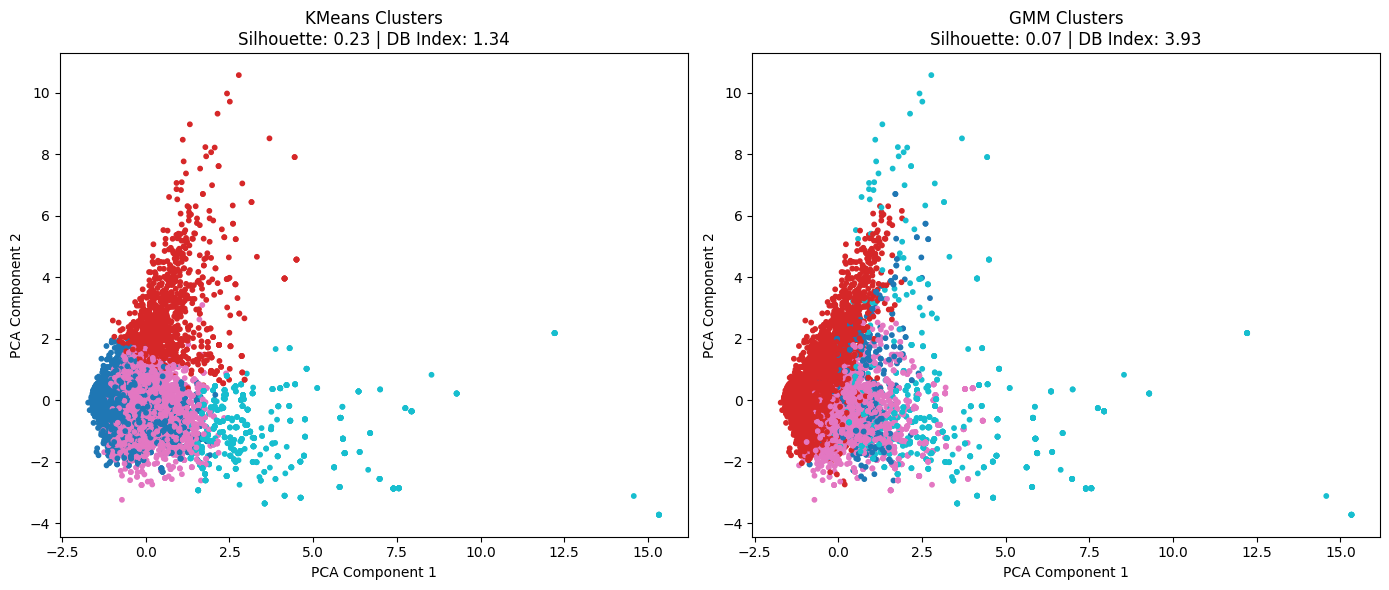

In [20]:
# PCA for 2D Visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)

# Plot Clusters
fig, axes = plt.subplots(1, 2, figsize=(14, 6))
models = ['KMeans', 'GMM']
labels_list = [kmeans_labels, gmm_labels]
scores = [(kmeans_silhouette, kmeans_db_index), (gmm_silhouette, gmm_db_index)]

for ax, model, labels, (sil, db) in zip(axes, models, labels_list, scores):
    scatter = ax.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='tab10', s=10)
    ax.set_title(f'{model} Clusters\nSilhouette: {sil:.2f} | DB Index: {db:.2f}')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')

plt.tight_layout()
plt.show()


In [21]:
# Print evaluation
print({
    "KMeans": {"Silhouette Score": kmeans_silhouette, "Davies-Bouldin Index": kmeans_db_index},
    "GMM": {"Silhouette Score": gmm_silhouette, "Davies-Bouldin Index": gmm_db_index}
})


{'KMeans': {'Silhouette Score': np.float64(0.23470864776162748), 'Davies-Bouldin Index': np.float64(1.342992944566599)}, 'GMM': {'Silhouette Score': np.float64(0.06629778047574095), 'Davies-Bouldin Index': np.float64(3.9346318739876396)}}


/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(


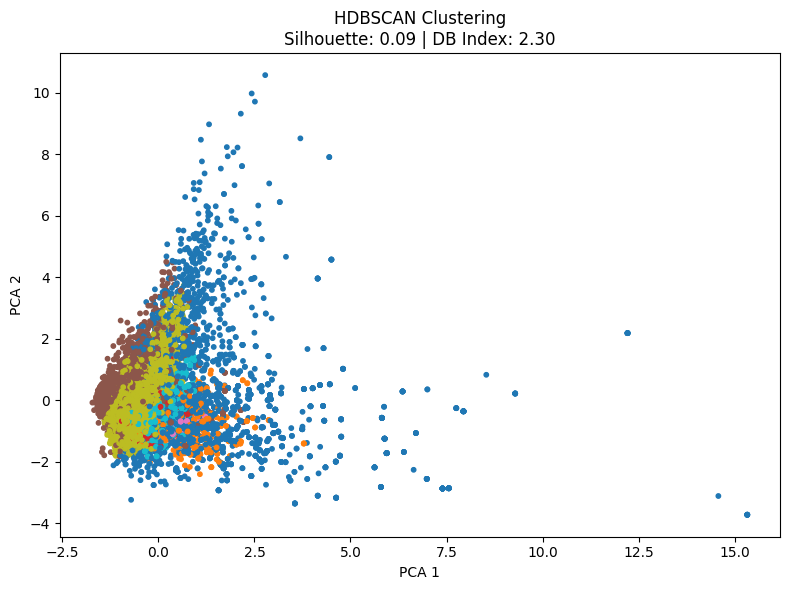

In [22]:
import hdbscan
# Fit HDBSCAN
hdb = hdbscan.HDBSCAN(min_cluster_size=30)
hdb_labels = hdb.fit_predict(X)


# Filter noise (-1 labels)
mask = hdb_labels != -1
if mask.sum() > 0:
    hdb_silhouette = silhouette_score(X[mask], hdb_labels[mask])
    hdb_db_index = davies_bouldin_score(X[mask], hdb_labels[mask])
else:
    hdb_silhouette, hdb_db_index = -1, -1

# Visualize
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=hdb_labels, cmap='tab10', s=10)
plt.title(f"HDBSCAN Clustering\nSilhouette: {hdb_silhouette:.2f} | DB Index: {hdb_db_index:.2f}")
plt.xlabel("PCA 1")
plt.ylabel("PCA 2")
plt.tight_layout()
plt.show()

In [23]:
print(f"HDBSCAN Silhouette Score: {hdb_silhouette:.2f}")
print(f"HDBSCAN Davies-Bouldin Index: {hdb_db_index:.2f}")

HDBSCAN Silhouette Score: 0.09
HDBSCAN Davies-Bouldin Index: 2.30


In [25]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix
import joblib

# Use KMeans labels as targets
y = kmeans_labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [26]:
# Train Random Forest
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)


RandomForestClassifier(random_state=42)

In [27]:
# Evaluation
y_pred = clf.predict(X_test)
print("Classification Report:\n", classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))


Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.99       892
           1       0.98      1.00      0.99       216
           2       1.00      0.99      0.99      1073
           3       0.99      1.00      0.99       135

    accuracy                           0.99      2316
   macro avg       0.99      0.99      0.99      2316
weighted avg       0.99      0.99      0.99      2316

Confusion Matrix:
 [[ 885    2    3    2]
 [   0  215    1    0]
 [  14    2 1057    0]
 [   0    0    0  135]]


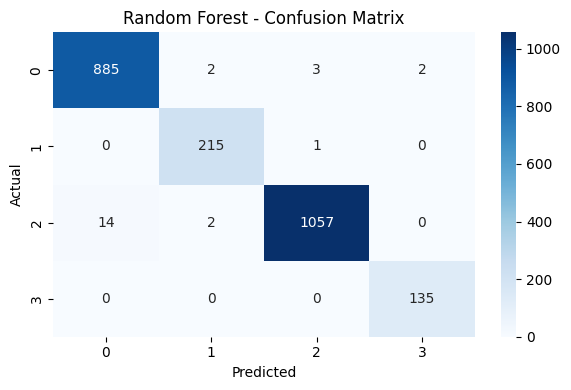

In [29]:
#Confusion Matrix
import seaborn as sns
from sklearn.metrics import confusion_matrix
plt.figure(figsize=(6, 4))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt='d', cmap='Blues')
plt.title("Random Forest - Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.show()

In [30]:
# Save model and scaler
joblib.dump(clf, 'customer_segment_model.pkl')
joblib.dump(scaler, 'scaler.pkl')

['scaler.pkl']